# Offline Reinforcement Learning Training

### Project Overview

The project aims to model a compressor dataset to predict and manage changes in compressor parameters, ultimately maintaining stable compressor pressure. Initially, the dataset, containing parameters like discharge pressure, superheat, and temperature, is preprocessed and augmented with additional features. Modelling techniques, including ensemble methods and reinforcement learning (RL), are employed to train the model. The RL approach utilizes a custom Gym environment where an agent interacts with the compressor system, adjusting parameters to optimize stability while minimizing energy consumption. By integrating machine learning and RL, the project aims to provide a comprehensive solution for efficient and stable compressor operation, essential for various industrial applications.

### Import Library

In [26]:
# Utilities
import pandas as pd
import numpy as np
import pickle
import random
import os

# Deep Learning
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam

# Reinforcement Learning
from gym import Env
from gym.spaces import Discrete, Box
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# Visualization
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "svg" # static plotly

import warnings
warnings.filterwarnings('ignore')

### Load Compressor Machine Model

In [2]:
scalerfile = './scaler.sav'
min_max_scaler = pickle.load(open(scalerfile, 'rb'))

In [3]:
predictor = load_model('./Compressor_Machine.keras')

### Build RL Model

In [5]:
import random
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box

class CompressorDischargePressure(Env):
    def __init__(self):
        """
        Initializes the compressor environment.
        """
        # Define action space
        self.d1 = 0  # Decrease suction pressure (0)
        self.u1 = 1  # Increase suction pressure (1)
        self.d2 = 2  # Decrease discharge superheat (2)
        self.u2 = 3  # Increase discharge superheat (3)
        self.d3 = 4  # Decrease discharge temperature (4)
        self.u3 = 5  # Increase discharge temperature (5)
        self.action_space = Discrete(6)

        # Define observation space
        self.observation_space = Box(low=np.array([0]), high=np.array([15]))

        # Initialize current state
        self.suct_press = random.randint(0, 13)
        self.disch_superheat = random.randint(0, 120)
        self.disch_temp = random.randint(20, 80)
        self.state = predictor.predict(min_max_scaler.transform([[self.disch_superheat, self.disch_temp, self.suct_press]]))[0][0]

        # Set target discharge pressure and error
        self.target_disch_pressure = 10
        self.target_error = abs(self.target_disch_pressure - self.state)

    def step(self, action):
        """
        Perform one step within the environment.
        """
        # Apply action
        if action == self.d1:
            self.suct_press -= 0.5
        elif action == self.u1:
            self.suct_press += 0.5
        elif action == self.d2:
            self.disch_superheat -= 5
        elif action == self.u2:
            self.disch_superheat += 5
        elif action == self.d3:
            self.disch_temp -= 5
        elif action == self.u3:
            self.disch_temp += 5

        # Update state
        self.state = predictor.predict(min_max_scaler.transform([[self.disch_superheat, self.disch_temp, self.suct_press]]))[0][0]

        # Calculate reward based on the distance from the target discharge pressure
        reward = -abs(self.target_disch_pressure - self.state)

        # Check if episode is done
        done = abs(self.target_disch_pressure - self.state) < 0.5

        info = {}
        return self.state, reward, done, info

    def render(self, mode='human'):
        """
        Render the environment.
        """
        pass

    def reset(self):
        """
        Reset the environment.
        """
        self.suct_press = random.randint(0, 13)
        self.disch_superheat = random.randint(0, 120)
        self.disch_temp = random.randint(20, 80)
        self.state = predictor.predict(min_max_scaler.transform([[self.disch_superheat, self.disch_temp, self.suct_press]]))[0][0]

        return self.state

In [6]:
env = CompressorDischargePressure()

In [7]:
env.action_space.sample()

3

In [8]:
# episodes = 100
# for episode in range(1, episodes+1):
#     state = env.reset()
#     done = False
#     score = 0
    
#     while not done:
#         action = env.action_space.sample()
#         state, reward, done, info = env.step(action)
#         score += reward
    
#     print('Episode:{} Score:{}'.format(episode, score))

In [9]:
states = env.observation_space.shape
actions = env.action_space.n

In [10]:
env.action_space

Discrete(6)

In [11]:
actions

6

In [12]:
def set_seed_TF2(seed):
    """
    Set seed for TensorFlow 2 and other libraries for reproducibility.

    Args:
    - seed (int): Seed value to set for random number generation.

    Returns:
    - None
    """
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
def build_model(states, actions):
    """
    Build a neural network model for the given states and actions.

    Args:
    - states (tuple): Shape of the input states.
    - actions (int): Number of possible actions.

    Returns:
    - model (Sequential): Neural network model.
    """
    set_seed_TF2(31)
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear'))
    return model

In [14]:
# del model

In [15]:
model = build_model(states, actions)

In [16]:
model.layers

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                48        
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 150       
                                                                 
Total params: 798 (3.12 KB)
Trainable params: 798 (3.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
def build_agent(model, actions):
    """
    Build a DQN agent with the specified model and number of actions.

    Args:
    - model (Sequential): Neural network model.
    - actions (int): Number of possible actions.

    Returns:
    - dqn (DQNAgent): Deep Q-Network agent.
    """
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [19]:
# Build DQN agent
dqn = build_agent(model, actions)

# Compile the agent
dqn.compile(optimizer=Adam(lr=1e-3), metrics=['mae'])

# Train the agent
dqn.fit(env, nb_steps=2000000, visualize=True, verbose=1)


Training for 2000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -9.9496
Interval 2 (10000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -10.0110
Interval 3 (20000 steps performed)
10000/10000 [==============================] - 78s 8ms/step - reward: -9.9509
Interval 4 (30000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -9.9696
Interval 5 (40000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -9.8718
Interval 6 (50000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -9.7177
Interval 7 (60000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -9.8123
Interval 8 (70000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.9253
Interval 9 (80000 steps performed)
10000/10000 [===================

### Evaluation

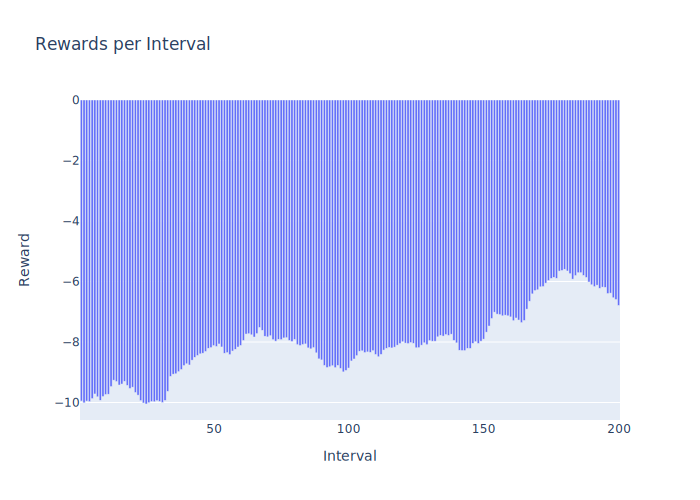

In [27]:
import re

# Sample log text
data = """
Training for 2000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -9.9496
Interval 2 (10000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -10.0110
Interval 3 (20000 steps performed)
10000/10000 [==============================] - 78s 8ms/step - reward: -9.9509
Interval 4 (30000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -9.9696
Interval 5 (40000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -9.8718
Interval 6 (50000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -9.7177
Interval 7 (60000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -9.8123
Interval 8 (70000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.9253
Interval 9 (80000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.8026
Interval 10 (90000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -9.7354
Interval 11 (100000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.7248
Interval 12 (110000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.4734
Interval 13 (120000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -9.2607
Interval 14 (130000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -9.3053
Interval 15 (140000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.4214
Interval 16 (150000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -9.3890
Interval 17 (160000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.2988
Interval 18 (170000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -9.4324
Interval 19 (180000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.5346
Interval 20 (190000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -9.4920
Interval 21 (200000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -9.6677
Interval 22 (210000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -9.7558
Interval 23 (220000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -9.9347
Interval 24 (230000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -10.0144
Interval 25 (240000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -10.0492
Interval 26 (250000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -10.0046
Interval 27 (260000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -9.9659
Interval 28 (270000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -9.9761
Interval 29 (280000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -9.9388
Interval 30 (290000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -9.9648
Interval 31 (300000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -9.9982
Interval 32 (310000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -9.9306
Interval 33 (320000 steps performed)
10000/10000 [==============================] - 99s 10ms/step - reward: -9.6304
Interval 34 (330000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -9.1342
Interval 35 (340000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -9.0620
Interval 36 (350000 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -9.0513
Interval 37 (360000 steps performed)
10000/10000 [==============================] - 99s 10ms/step - reward: -8.9797
Interval 38 (370000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -8.9080
Interval 39 (380000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -8.7777
Interval 40 (390000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -8.7206
Interval 41 (400000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -8.7592
Interval 42 (410000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -8.5988
Interval 43 (420000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -8.5040
Interval 44 (430000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -8.4446
Interval 45 (440000 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -8.3921
Interval 46 (450000 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -8.3689
Interval 47 (460000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -8.3119
Interval 48 (470000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -8.2067
Interval 49 (480000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.1850
Interval 50 (490000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -8.1178
Interval 51 (500000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.1470
Interval 52 (510000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -8.0649
Interval 53 (520000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -8.1641
Interval 54 (530000 steps performed)
10000/10000 [==============================] - 104s 10ms/step - reward: -8.3701
Interval 55 (540000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -8.3507
Interval 56 (550000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -8.4158
Interval 57 (560000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -8.2982
Interval 58 (570000 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -8.2404
Interval 59 (580000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -8.1655
Interval 60 (590000 steps performed)
10000/10000 [==============================] - 104s 10ms/step - reward: -8.1129
Interval 61 (600000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -7.9458
Interval 62 (610000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -7.7367
Interval 63 (620000 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: -7.7272
Interval 64 (630000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -7.7628
Interval 65 (640000 steps performed)
10000/10000 [==============================] - 117s 12ms/step - reward: -7.8347
Interval 66 (650000 steps performed)
10000/10000 [==============================] - 115s 12ms/step - reward: -7.7222
Interval 67 (660000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -7.5169
Interval 68 (670000 steps performed)
10000/10000 [==============================] - 114s 11ms/step - reward: -7.6123
Interval 69 (680000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -7.8084
Interval 70 (690000 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: -7.8312
Interval 71 (700000 steps performed)
10000/10000 [==============================] - 143s 14ms/step - reward: -7.7917
Interval 72 (710000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -7.9230
Interval 73 (720000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -7.9709
Interval 74 (730000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: -7.9094
Interval 75 (740000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -7.9208
Interval 76 (750000 steps performed)
10000/10000 [==============================] - 103s 10ms/step - reward: -7.8651
Interval 77 (760000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -7.8573
Interval 78 (770000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -7.9444
Interval 79 (780000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -7.9808
Interval 80 (790000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -7.9132
Interval 81 (800000 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -8.0884
Interval 82 (810000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -8.1162
Interval 83 (820000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -8.0821
Interval 84 (830000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.0637
Interval 85 (840000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -8.1947
Interval 86 (850000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -8.2272
Interval 87 (860000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -8.1834
Interval 88 (870000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.3589
Interval 89 (880000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.5579
Interval 90 (890000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.5924
Interval 91 (900000 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -8.7724
Interval 92 (910000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.8425
Interval 93 (920000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.8193
Interval 94 (930000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.7830
Interval 95 (940000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -8.8481
Interval 96 (950000 steps performed)
10000/10000 [==============================] - 95s 9ms/step - reward: -8.7717
Interval 97 (960000 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -8.8710
Interval 98 (970000 steps performed)
10000/10000 [==============================] - 95s 10ms/step - reward: -8.9881
Interval 99 (980000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.9387
Interval 100 (990000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -8.8606
Interval 101 (1000000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.6268
Interval 102 (1010000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.5612
Interval 103 (1020000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -8.4512
Interval 104 (1030000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -8.3045
Interval 105 (1040000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2927
Interval 106 (1050000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.3486
Interval 107 (1060000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.3276
Interval 108 (1070000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -8.3403
Interval 109 (1080000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.2873
Interval 110 (1090000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.4104
Interval 111 (1100000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.4886
Interval 112 (1110000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -8.4078
Interval 113 (1120000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2660
Interval 114 (1130000 steps performed)
10000/10000 [==============================] - 18659s 2s/step - reward: -8.2076
Interval 115 (1140000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -8.1752
Interval 116 (1150000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -8.1965
Interval 117 (1160000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -8.1684
Interval 118 (1170000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -8.1032
Interval 119 (1180000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -8.0497
Interval 120 (1190000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -7.9911
Interval 121 (1200000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -8.0349
Interval 122 (1210000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -8.0520
Interval 123 (1220000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -8.0165
Interval 124 (1230000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -8.0423
Interval 125 (1240000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -8.1919
Interval 126 (1250000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -8.1879
Interval 127 (1260000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -8.1035
Interval 128 (1270000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -8.0267
Interval 129 (1280000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -8.0896
Interval 130 (1290000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.9507
Interval 131 (1300000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.9722
Interval 132 (1310000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.9715
Interval 133 (1320000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.8297
Interval 134 (1330000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.7779
Interval 135 (1340000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -7.8038
Interval 136 (1350000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -7.7539
Interval 137 (1360000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -7.7808
Interval 138 (1370000 steps performed)
10000/10000 [==============================] - 522s 52ms/step - reward: -7.7403
Interval 139 (1380000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -7.9428
Interval 140 (1390000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.0288
Interval 141 (1400000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2721
Interval 142 (1410000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2819
Interval 143 (1420000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2842
Interval 144 (1430000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -8.2084
Interval 145 (1440000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.2097
Interval 146 (1450000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.0439
Interval 147 (1460000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -7.9854
Interval 148 (1470000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -8.0476
Interval 149 (1480000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -7.9703
Interval 150 (1490000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -7.9043
Interval 151 (1500000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.6739
Interval 152 (1510000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -7.4718
Interval 153 (1520000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.2220
Interval 154 (1530000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.0127
Interval 155 (1540000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.0774
Interval 156 (1550000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.0932
Interval 157 (1560000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.1351
Interval 158 (1570000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.1115
Interval 159 (1580000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.1348
Interval 160 (1590000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -7.1702
Interval 161 (1600000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -7.2959
Interval 162 (1610000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -7.2060
Interval 163 (1620000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -7.2737
Interval 164 (1630000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -7.3591
Interval 165 (1640000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -7.2872
Interval 166 (1650000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -6.9123
Interval 167 (1660000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -6.6503
Interval 168 (1670000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -6.4093
Interval 169 (1680000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -6.3001
Interval 170 (1690000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -6.2749
Interval 171 (1700000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -6.1769
Interval 172 (1710000 steps performed)
10000/10000 [==============================] - 85s 8ms/step - reward: -6.1668
Interval 173 (1720000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -6.0532
Interval 174 (1730000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -5.9646
Interval 175 (1740000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.8963
Interval 176 (1750000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.8594
Interval 177 (1760000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.8926
Interval 178 (1770000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.6546
Interval 179 (1780000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.6345
Interval 180 (1790000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.5939
Interval 181 (1800000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -5.6527
Interval 182 (1810000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -5.7419
Interval 183 (1820000 steps performed)
10000/10000 [==============================] - 5381s 538ms/step - reward: -5.9200
Interval 184 (1830000 steps performed)
10000/10000 [==============================] - 99s 10ms/step - reward: -5.8031
Interval 185 (1840000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -5.7108
Interval 186 (1850000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -5.7100
Interval 187 (1860000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -5.7977
Interval 188 (1870000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -5.8647
Interval 189 (1880000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -6.0157
Interval 190 (1890000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -6.1095
Interval 191 (1900000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -6.1691
Interval 192 (1910000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -6.1196
Interval 193 (1920000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -6.2237
Interval 194 (1930000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -6.1846
Interval 195 (1940000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -6.1923
Interval 196 (1950000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -6.3978
Interval 197 (1960000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -6.3830
Interval 198 (1970000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -6.5383
Interval 199 (1980000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -6.5947
Interval 200 (1990000 steps performed)
10000/10000 [==============================] - 105s 11ms/step - reward: -6.7895
...
"""

# Regular expressions to extract intervals and rewards
interval_regex = re.compile(r"Interval (\d+) \((\d+) steps performed\)")
reward_regex = re.compile(r"reward: (-?\d+\.\d+)")

# Extract rewards and intervals
rewards = []
intervals = []
for line in data.split('\n'):
    if 'Interval' in line:
        interval_num = int(line.split()[1])
        intervals.append(interval_num)
    elif 'reward:' in line:
        reward = float(line.split(':')[-1].strip())
        rewards.append(reward)

# Create bar plot
fig = go.Figure(data=[go.Bar(x=intervals, y=rewards)])
fig.update_layout(title='Rewards per Interval',
                  xaxis_title='Interval',
                  yaxis_title='Reward')
fig.show()

The provided reinforcement learning results show the training progress of an agent over 2,000,000 steps. The training intervals, each comprising 10,000 steps, exhibit a gradual improvement in the agent's performance as indicated by the reward values. Initially, the reward is highly negative, suggesting that the agent's actions lead to poor outcomes. However, as training progresses, the reward gradually increases, indicating that the agent is learning to make better decisions and achieve more favorable outcomes. The reward values fluctuate over time, indicating the iterative nature of reinforcement learning where the agent continually refines its policy through trial and error.

Despite the overall upward trend in rewards, there are occasional dips or plateaus, suggesting periods where the agent struggles to make progress or encounters new challenges. However, the overall trajectory of the reward curve demonstrates the effectiveness of the training process in gradually improving the agent's performance.